In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Uppgift: #0**

---

We want to simulate data $(x,y)$ to represent cost for phone subscriptions, with: 

- $x$ - called minutes per month
- $y$ - SEK per month 

&nbsp; a) Use ```numpy.random.normal()``` to simulate a dataset with the following requirements:(*)
- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v. $X \sim \mathcal{N}(100, 100)$ 
- take absolute value of these x-values
- simulate noise 400 noise values from r.v. $\epsilon \sim \mathcal{N(0, 50)}$ 
- Let $y = 2x+25+\epsilon$
- plot the data set 

&nbsp; b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\beta_0 = 25, \beta_1 = 2$

&nbsp; c) Insert the values into a DataFrame (*)

---

**a)**

<Axes: xlabel='called minutes per month', ylabel='SEK per month'>

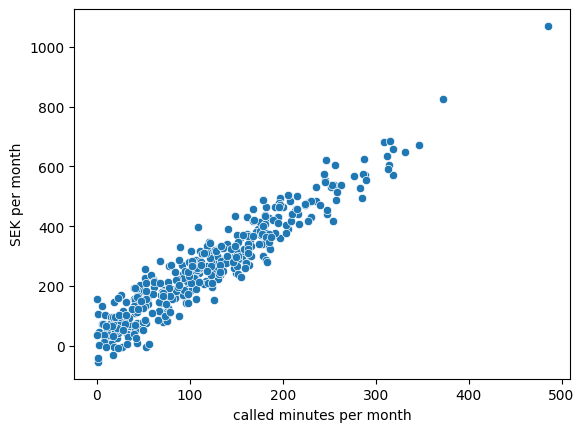

In [31]:
np.random.seed(42)

x = np.abs(np.random.normal(loc=100, scale=100, size=400))
noise = np.random.normal(loc= 0, scale=50, size= 400)

y_data = lambda x, noise: (2*x) + 25 + noise
y = y_data(x=x, noise=noise)


data = {"called minutes per month": x,
        "SEK per month": y}

df = pd.DataFrame(data= data)

sns.scatterplot(data= df, x="called minutes per month", y="SEK per month")

**b) and c)**

In [32]:
df_over_300 = df[df["called minutes per month"] > 300].index
df.drop(df_over_300, inplace=True)

df_negativ = df[df["SEK per month"] < 0].index
df.drop(df_negativ, inplace=True)

df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 399
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   called minutes per month  381 non-null    float64
 1   SEK per month             381 non-null    float64
dtypes: float64(2)
memory usage: 8.9 KB


<Axes: xlabel='called minutes per month', ylabel='SEK per month'>

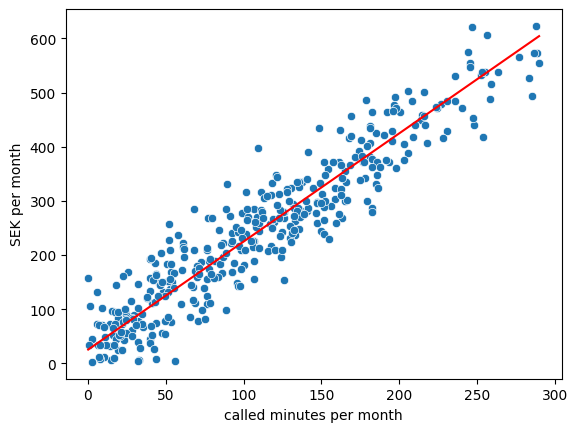

In [33]:
ground_truth = lambda x: 25 + 2*x

x = df["called minutes per month"]

sns.scatterplot(data=df, x="called minutes per month", y="SEK per month")
sns.lineplot(x= x, y= ground_truth(x), color= "red")

## **Uppgift: #1**

---

Before moving on with linear regression we shall first perform a train-test-split. 

&nbsp; a) Create a train-test-split function with the following call signature: (*)

```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple
```

that returns the tuple:
```
(X_train, X_test, y_train, y_test)
```

&nbsp; b) Now use this to split up your data into a training set and test set. Check manually that the split is performed correctly. (*)

---

**a)**

In [34]:
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction: float, random_state: int, replace: bool) -> tuple:

    train_fraction = int(len(X)*train_fraction)

    trian_sample_X = X.sample(n= train_fraction, random_state= random_state, replace= replace)
    trian_sample_y = y.sample(n= train_fraction, random_state= random_state, replace= replace)

    test_sample_X = X.drop(trian_sample_X.index)
    test_sample_y = y.drop(trian_sample_y.index)

    X_trian, y_trian = pd.DataFrame(trian_sample_X), trian_sample_y
    X_test, y_test = pd.DataFrame(test_sample_X), test_sample_y

    X_trian.insert(0, "intercept", 1)
    X_test.insert(0, "intercept", 1)

    return (X_trian, y_trian, X_test, y_test)

**b)**

In [35]:
X_trian, y_trian, X_test, y_test = train_test_split(df["called minutes per month"], df["SEK per month"], train_fraction=0.7, random_state=42, replace=False)

X_trian.shape, y_trian.shape, X_test.shape, y_test.shape

((266, 2), (266,), (115, 2), (115,))

## **Uppgift: #2**

---

Use the normal equation for simple linear regression to solve for the coefficients $\hat{\beta} = (\beta_0, \beta_1)$. Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data.

---

In [46]:
regression_fit = lambda X, y: np.linalg.inv(X.T@X) @ X.T @ y
predict = lambda X, weights: X @ weights

beta_hat = regression_fit(X_trian, y_trian)

type(beta_hat)


pandas.core.series.Series

In [37]:
regression_line = lambda x, b0, b1: b0 + (b1*x)

reg_line = regression_line(X_trian, beta_hat[0], beta_hat[1])

reg_line

,intercept,called minutes per month
277,34.131983,108.600279
196,34.131983,54.410583
46,34.131983,135.266759
55,34.131983,401.193686
57,34.131983,164.196861
...,...,...
41,34.131983,256.012080
306,34.131983,467.370703
211,34.131983,440.222556
264,34.131983,175.018774


<Axes: xlabel='called minutes per month', ylabel='SEK per month'>

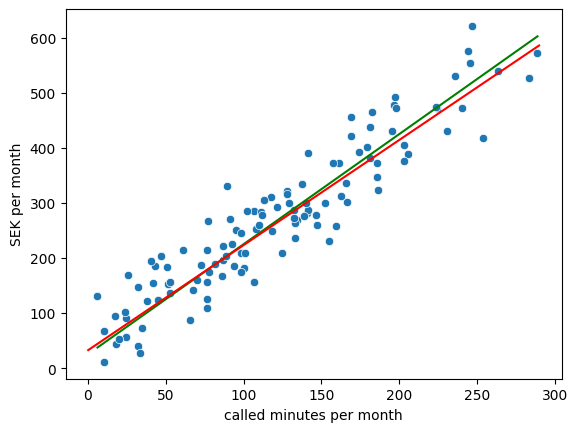

In [38]:
sns.scatterplot(x=X_test["called minutes per month"], y=y_test)
sns.lineplot(x= X_test["called minutes per month"], y= ground_truth(x), color= "green")
sns.lineplot(x= x, y= reg_line["called minutes per month"], color= "red")

## **Uppgift: #3**

---

&nbsp; a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

&nbsp; b) Calculate MAE, MSE, RMSE (*)

---

**a)**

<Axes: xlabel='called minutes per month', ylabel='SEK per month'>

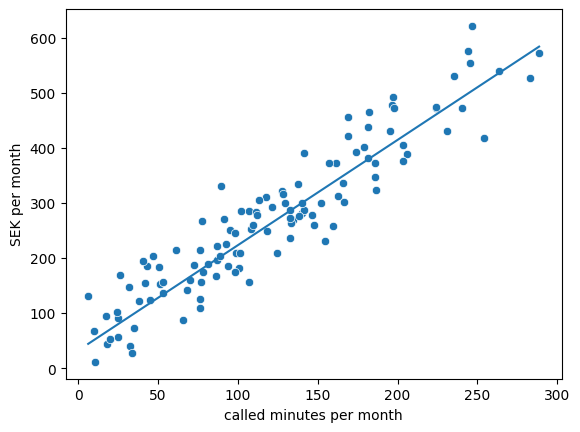

In [39]:
predict = lambda X, weights: X @ weights

beta_hat = np.reshape(beta_hat.to_numpy(), (2,1))

y_hat = predict(X_test, beta_hat).to_numpy()
y_hat = np.reshape(y_hat, -1)

sns.scatterplot(x=X_test["called minutes per month"], y= y_test)
sns.lineplot(x=X_test["called minutes per month"], y= y_hat)

**b)**

In [43]:
m = len(y_test)
y_hat = np.reshape(y_hat, (m))

mae = 1/m*np.sum(np.abs(y_test-y_hat))
mse = 1/m*np.sum((y_test-y_hat)**2)
rmse = np.sqrt(mse)

mae, mse, rmse


(40.120026511492135, 2401.5771288677297, 49.00588871623215)